In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = models.alexnet(weights=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:

def normalize_data(x):
    x_min = torch.min(x, dim=1, keepdim=True)[0] 
    x_max = torch.max(x, dim=1, keepdim=True)[0]
    x_norm = torch.sub(x, x_min) 
    x_norm = torch.div(x_norm, x_max - x_min)
    return x_norm


def Dataloader():    
    transform = Compose([Resize((224,224)),ToTensor(),Lambda(normalize_data)])
    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    classes = [0,1]
    train_data = [x for x in train_data if x[1] in classes]
    test_data = [x for x in test_data if x[1] in classes]
    return train_data,test_data

In [6]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0006)
train_loss = []
train_accuracy = []

In [7]:
train_data,test_data = Dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [8]:

train = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
for epoch in range(5):
    epoch_train_loss = 0.0
    correct_pred = 0
    total_samples = 0
    for images, labels in train:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        _, predicted_labels = torch.max(out.data,1)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        total_samples += labels.size(0)
        correct_pred += (predicted_labels == labels).sum().item() 
    epoch_train_accuracy = 100 * correct_pred / total_samples
    train_accuracy.append(epoch_train_accuracy)
    train_loss.append(epoch_train_loss)
    print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")

Epoch 1 - Train Loss: 41.9480, Train Accuracy: 88.86%
Epoch 2 - Train Loss: 32.9979, Train Accuracy: 91.27%
Epoch 3 - Train Loss: 31.2409, Train Accuracy: 91.86%
Epoch 4 - Train Loss: 31.0780, Train Accuracy: 91.52%
Epoch 5 - Train Loss: 30.3371, Train Accuracy: 92.29%


In [ ]:
out.data

In [ ]:
predicted_labels

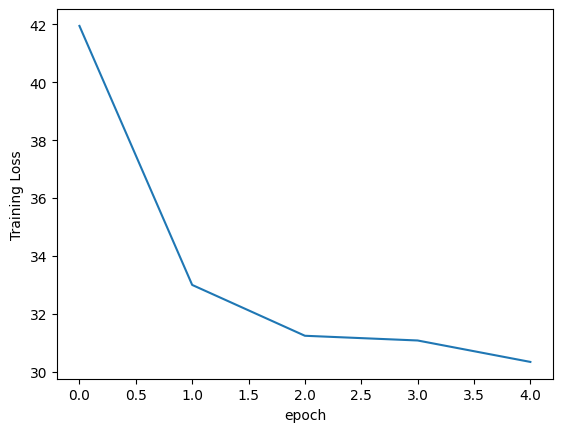

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.plot(train_loss)
plt.xlabel('epoch') 
plt.ylabel('Training Loss') 
plt.show()

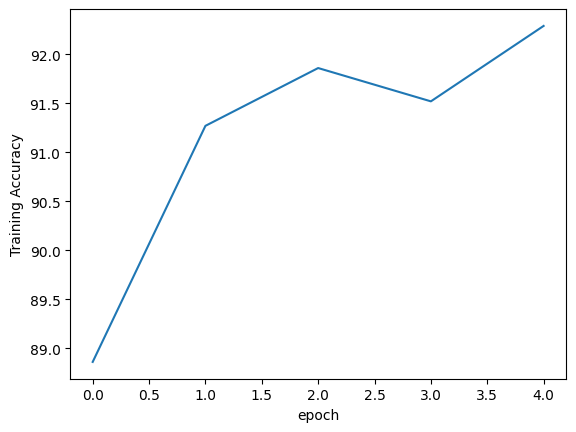

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.plot(train_accuracy)
plt.xlabel('epoch') 
plt.ylabel('Training Accuracy') 
plt.show()

In [12]:
for images, labels in test:
    images = images.to(device)  
    labels = labels.to(device)
    out = model(images)  
    _, predicted_labels = torch.max(out.data,1) 
    total_samples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum().item() 
test_accuracy = 100 * correct_pred / total_samples

In [13]:
test_accuracy

92.225

In [14]:
class Custome_Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset 
        self.labels = [x[1] for x in dataset] 
        self.indice_0 = {0: np.where(np.array(self.labels) == 0)[0]} 
        self.indice_1 = {1: np.where(np.array(self.labels) == 1)[0]} 
        self.indices = {}
        self.indices.update(self.indice_0)
        self.indices.update(self.indice_1)

    def __getitem__(self, index):
        anchor, positive_class = self.dataset[index]
        positive_index = np.random.choice(self.indices[positive_class])
        while positive_index == index:
            positive_index = np.random.choice(self.indices[positive_class])
        positive_data, pos_class = self.dataset[positive_index]
        if pos_class == 1:
            negative_class = 0
        elif pos_class == 0:
            negative_class = 1
        negative_index = np.random.choice(self.indices[negative_class]) 
        negative_data, neg_class = self.dataset[negative_index]
        return anchor, positive_data, negative_data,pos_class,neg_class
    
    def __len__(self):
        return len(self.dataset)

In [15]:
train_tri = Custome_Dataset(train_data)
test_tri = Custome_Dataset(test_data)
train_tri = torch.utils.data.DataLoader(train_tri, batch_size=64, shuffle=True)
test_tri = torch.utils.data.DataLoader(test_tri, batch_size=64, shuffle=False)

In [16]:
model2 = torchvision.models.alexnet(weights=True)
model2.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
model2 = model2.to(device)

In [22]:
criterion_tri = nn.TripletMarginLoss(margin=0.5)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0006)
train_loss_tri = []

In [23]:
for epoch2 in range(7):
    epoch_loss_triplet = 0.0
    for batch_index, (anchor, positive_data, negative_data,positive_class,negative_class) in enumerate(train_tri):
        anchor   = anchor.to(device)
        positive_data = positive_data.to(device)
        negative_data = negative_data.to(device)
        optimizer2.zero_grad()
        out1 = model2(anchor)
        out2 = model2(positive_data)
        out3 = model2(negative_data)
        loss2 = criterion_tri(out1,out2,out3)
        loss2.backward()
        optimizer2.step()
        epoch_loss_triplet += loss2.item()
    train_loss_tri.append(epoch_loss_triplet)
    print(f"Epoch {epoch2+1} - Train Loss: {epoch_loss_triplet:.4f}")

Epoch 1 - Train Loss: 86.5431
Epoch 2 - Train Loss: 78.7395
Epoch 3 - Train Loss: 78.5784
Epoch 4 - Train Loss: 78.5592
Epoch 5 - Train Loss: 78.5053
Epoch 6 - Train Loss: 78.5273
Epoch 7 - Train Loss: 78.5593


In [24]:
torch.save(model2.state_dict(),'Feature_extractor.pth')

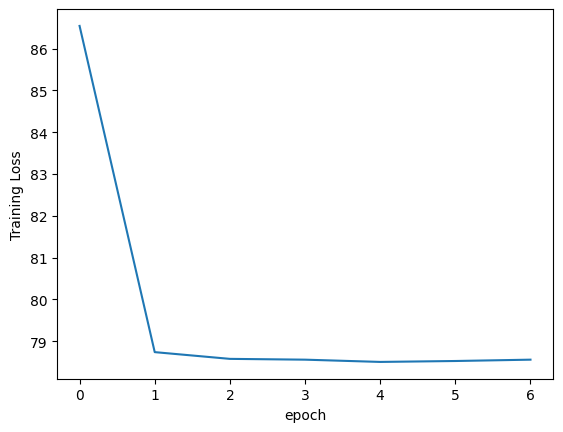

In [25]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.plot(train_loss_tri)
plt.xlabel('epoch') 
plt.ylabel('Training Loss') 
plt.show()

In [ ]:
model2

In [26]:
feature_weights = 'Feature_extractor.pth'


In [28]:
model_cf = torchvision.models.alexnet(weights=True)
model_cf.classifier = nn.Sequential(*list(model_cf.classifier.children())[:-2])
for param in model_cf.parameters():
    param.requires_grad = False
model_cf.load_state_dict(torch.load(feature_weights))
model_cf = model_cf.to(device)

In [29]:
model_cf.classifier.add_module("5", torch.nn.ReLU())
model_cf.classifier.add_module("6", torch.nn.Linear(4096, 2))

In [30]:


model_cf.classifier[5].requires_grad = True
model_cf.classifier[6].requires_grad = True

ce_loss = nn.CrossEntropyLoss()

In [31]:
model_cf = model_cf.to(device)

In [32]:
optimizer3 =  optim.Adam(model_cf.parameters(), lr=0.0009)
train_accuracy_cf = []
train_loss_cf = []

In [33]:
for epoch3 in range(10):
    epoch_loss_fc_tri = 0.0
    correct_pred_tri = 0
    total_samples_tri = 0
    for images3, labels3 in train:
        images3 = images3.to(device)
        labels3 = labels3.to(device)
        optimizer3.zero_grad()
        out_fc = model_cf(images3)
        _, predicted_labels3 = torch.max(out_fc.data,1)
        loss_fc = ce_loss(out_fc, labels3)
        loss_fc.backward()
        optimizer3.step()
        epoch_loss_fc_tri += loss_fc.item()
        total_samples_tri += labels3.size(0)
        correct_pred_tri += (predicted_labels3 == labels3).sum().item() 
    epoch_train_accuracy_tri = 100 * correct_pred_tri / total_samples_tri
    train_accuracy_cf.append(epoch_train_accuracy_tri)
    train_loss_cf.append(epoch_loss_fc_tri)
    print(f"Epoch {epoch3+1} - Train Loss: {epoch_loss_fc_tri:.4f}, Train Accuracy: {epoch_train_accuracy_tri:.2f}%")

Epoch 1 - Train Loss: 109.2924, Train Accuracy: 50.49%
Epoch 2 - Train Loss: 109.3908, Train Accuracy: 49.12%
Epoch 3 - Train Loss: 109.0708, Train Accuracy: 50.37%
Epoch 4 - Train Loss: 109.3456, Train Accuracy: 49.95%
Epoch 5 - Train Loss: 109.3562, Train Accuracy: 49.22%
Epoch 6 - Train Loss: 109.4345, Train Accuracy: 50.34%
Epoch 7 - Train Loss: 109.1234, Train Accuracy: 50.50%
Epoch 8 - Train Loss: 109.4680, Train Accuracy: 49.24%
Epoch 9 - Train Loss: 109.1196, Train Accuracy: 50.03%
Epoch 10 - Train Loss: 109.3617, Train Accuracy: 49.48%


In [34]:
model3 =  models.alexnet(weights=True)
model3 = model3.to(device)

In [35]:
triplet_loss = nn.TripletMarginLoss()
CE_Losss = nn.CrossEntropyLoss()
optimizer_f = optim.Adam(model3.parameters(), lr=0.0006)

In [36]:
train_accuracy_final = []
train_loss_final = []

In [37]:
labels.size(0)

16

In [38]:
for epoch3 in range(7):
    epoch_loss_final = 0.0
    correct_pred_final = 0
    total_samples_final = 0
    for batch_index, (anchors, pos_data, neg_data,pos_class,neg_class) in enumerate(train_tri):
        anchors   = anchors.to(device)
        pos_data = pos_data.to(device)
        neg_data = neg_data.to(device)
        pos_class = pos_class.to(device)
        neg_class = neg_class.to(device)
        outa = model3.features[12](anchors)
        outp = model3.features[12](pos_data)
        outn = model3.features[12](neg_data)
        out_finala = model3(anchors)
        out_finalp = model3(pos_data)
        out_finaln = model3(neg_data)
        optimizer_f.zero_grad()
        _, predicted_labela = torch.max(out_finala.data,1)
        _, predicted_labelp = torch.max(out_finalp.data,1)
        _, predicted_labeln = torch.max(out_finaln.data,1)
        loss_finala = CE_Losss(out_finala, pos_class)
        loss_finalp = CE_Losss(out_finalp, pos_class)
        loss_finaln = CE_Losss(out_finaln, neg_class)
        loss_triplet = triplet_loss(outa,outp,outn)
        loss_final = loss_finala+loss_finalp+loss_finaln+loss_triplet
        loss_final.backward()
        optimizer_f.step()
        epoch_loss_final += loss_final.item()
        total_samples_final += 3*(neg_class.size(0))
        correct_pred_final +=((predicted_labela == pos_class).sum().item() + (predicted_labelp == pos_class).sum().item() + (predicted_labeln == neg_class).sum().item())
    epoch_train_accuracy_final = 100 * correct_pred_final / total_samples_final
    train_accuracy_final.append(epoch_train_accuracy_final)
    train_loss_final.append(epoch_loss_final)
    print(f"Epoch {epoch3+1} - Train Loss: {epoch_loss_final:.4f}, Train Accuracy: {epoch_train_accuracy_final:.2f}%")

Epoch 1 - Train Loss: nan, Train Accuracy: 49.95%
Epoch 2 - Train Loss: nan, Train Accuracy: 49.44%
Epoch 3 - Train Loss: nan, Train Accuracy: 49.80%
Epoch 4 - Train Loss: nan, Train Accuracy: 50.21%
Epoch 5 - Train Loss: nan, Train Accuracy: 49.75%
Epoch 6 - Train Loss: nan, Train Accuracy: 49.72%
Epoch 7 - Train Loss: nan, Train Accuracy: 49.95%
